In [1]:
import io
import os
from tqdm.auto import tqdm
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

import torch.nn.functional as F

from transvae.trans_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.loss import vae_loss
from transvae.data import vae_data_gen 
from transvae.tvae_util import *

from rdkit import Chem

In [2]:
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

# Model Construction

### VAE & Information Bottleneck

COc1ccccc1OC(=O)Oc1ccccc1OC


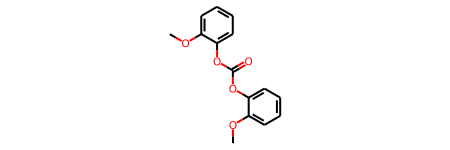

In [239]:
idx = 6
smi = attn_smiles[idx]
mol = Chem.MolFromSmiles(smi)
print(smi)
mol

In [272]:
import xml.etree.ElementTree as ET

def transparentsvg(svg):
    # Make the white background transparent
    svg = svg.replace('fill:#FFFFFF', 'fill:none')
    return svg

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

mol_svg = moltosvg(mol)
mol_svg = transparentsvg(mol_svg)
SVG(mol_svg)
with open('../../../publications/transvae/figs/arch_example.svg', 'w') as f:
    f.write(mol_svg)

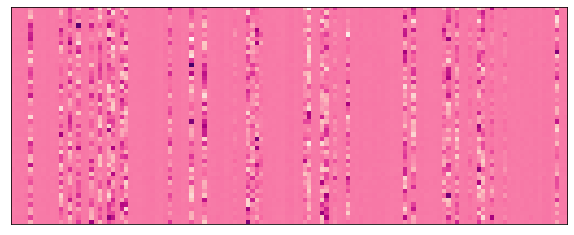

In [271]:
fig = plt.figure(figsize=(12,4))

mem = np.load('../fig_data/090_256_latent128_2milmoses_gruavae_v0.3_50mus.npy')
plt.imshow(mem, cmap='RdPu')
plt.xticks([])
plt.yticks([])
plt.show()

<IPython.core.display.Javascript object>


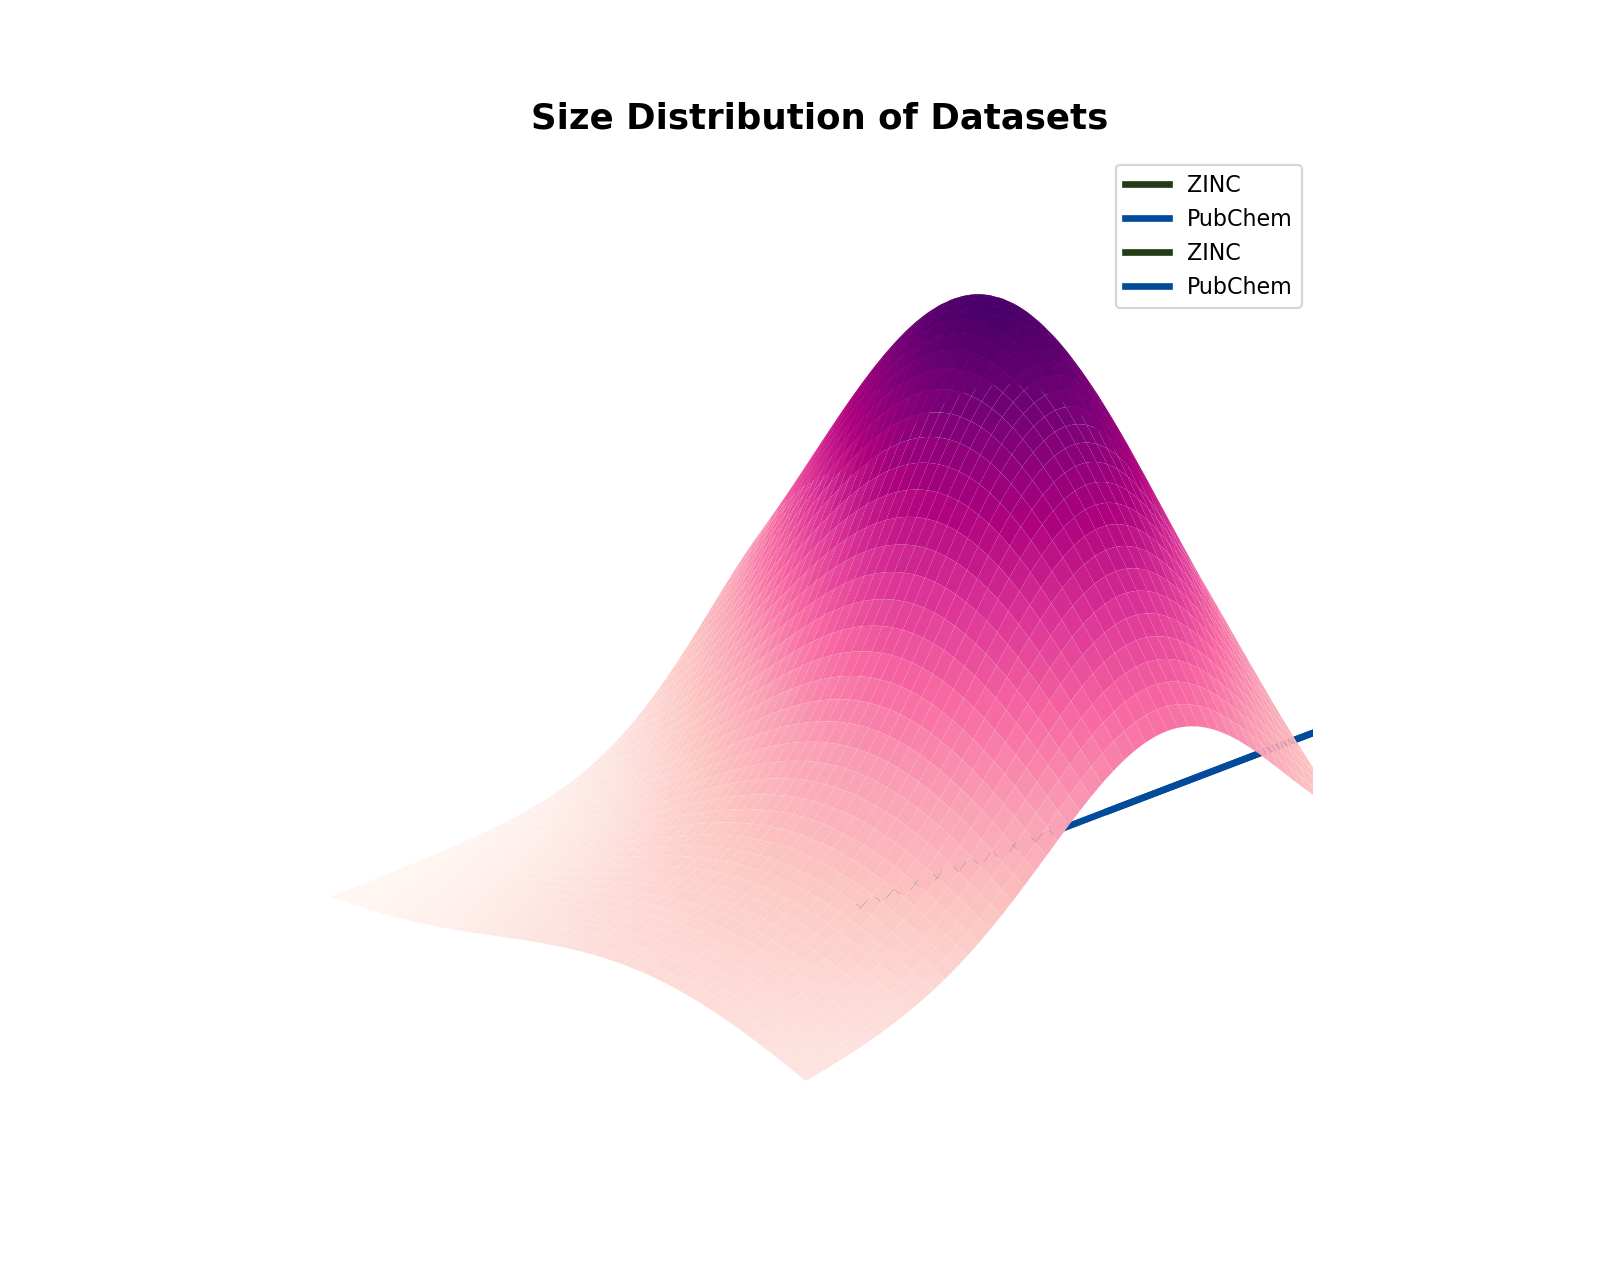

In [318]:
%matplotlib notebook
from scipy.stats import multivariate_normal

x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv1 = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
rv2 = multivariate_normal([np.random.rand(), np.random.rand()],
                          [[np.random.rand(), np.random.rand()],
                           [np.random.rand(), np.random.rand()]])

rv = rv1.pdf(pos) + rv2.pdf(pos)
fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, rv, cmap='RdPu')
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_axis_off()
plt.show()

In [319]:
plt.savefig('../../../publications/transvae/figs/latent_memory.png')

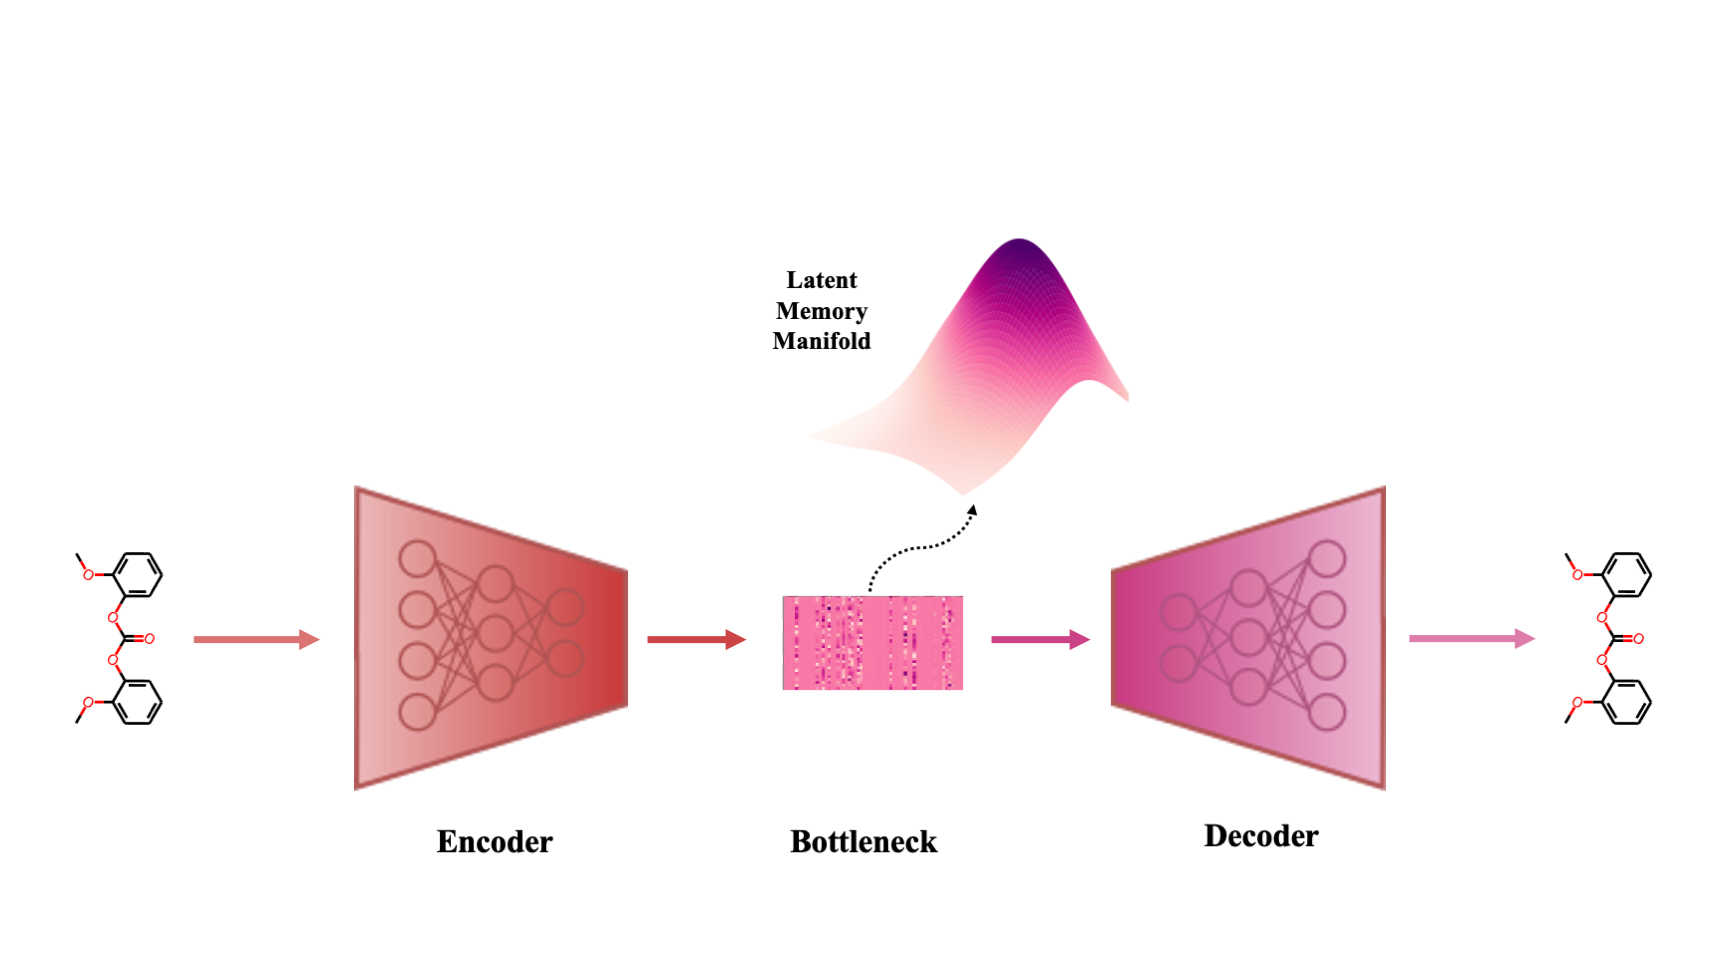

In [320]:
Image(filename='../../../publications/transvae/figs/fig1.png')

### Adding Attention to the VAE

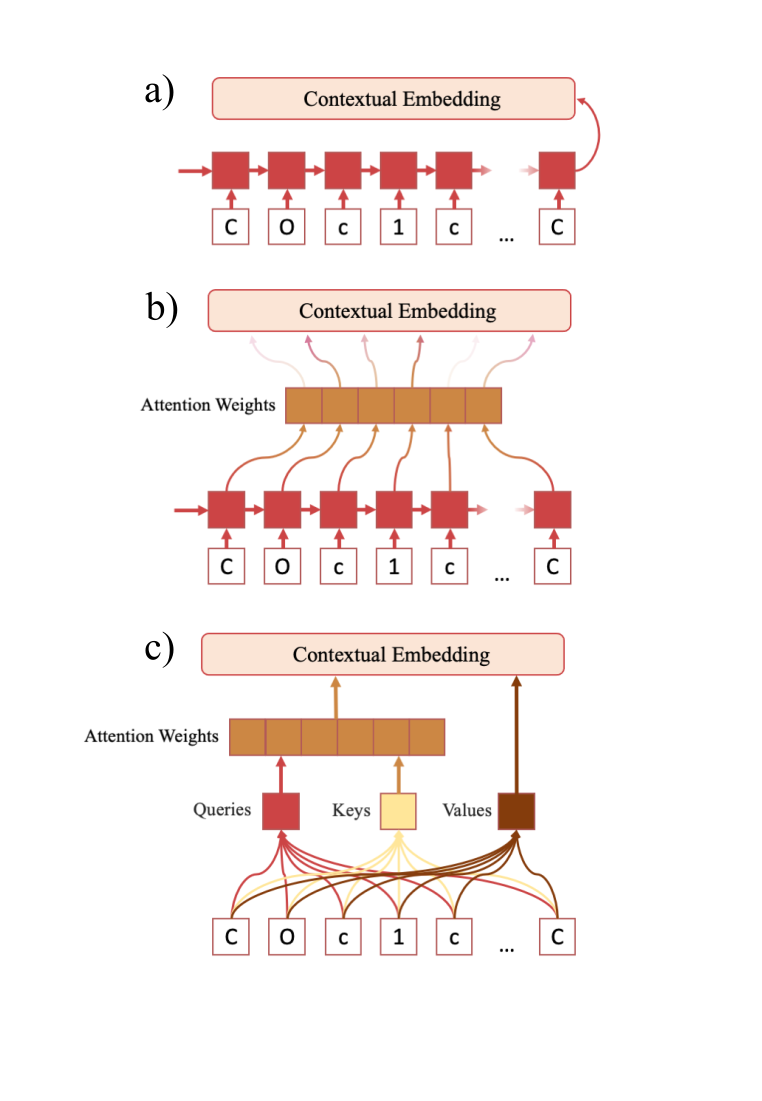

In [321]:
Image(filename='../../../publications/transvae/figs/fig2.png')

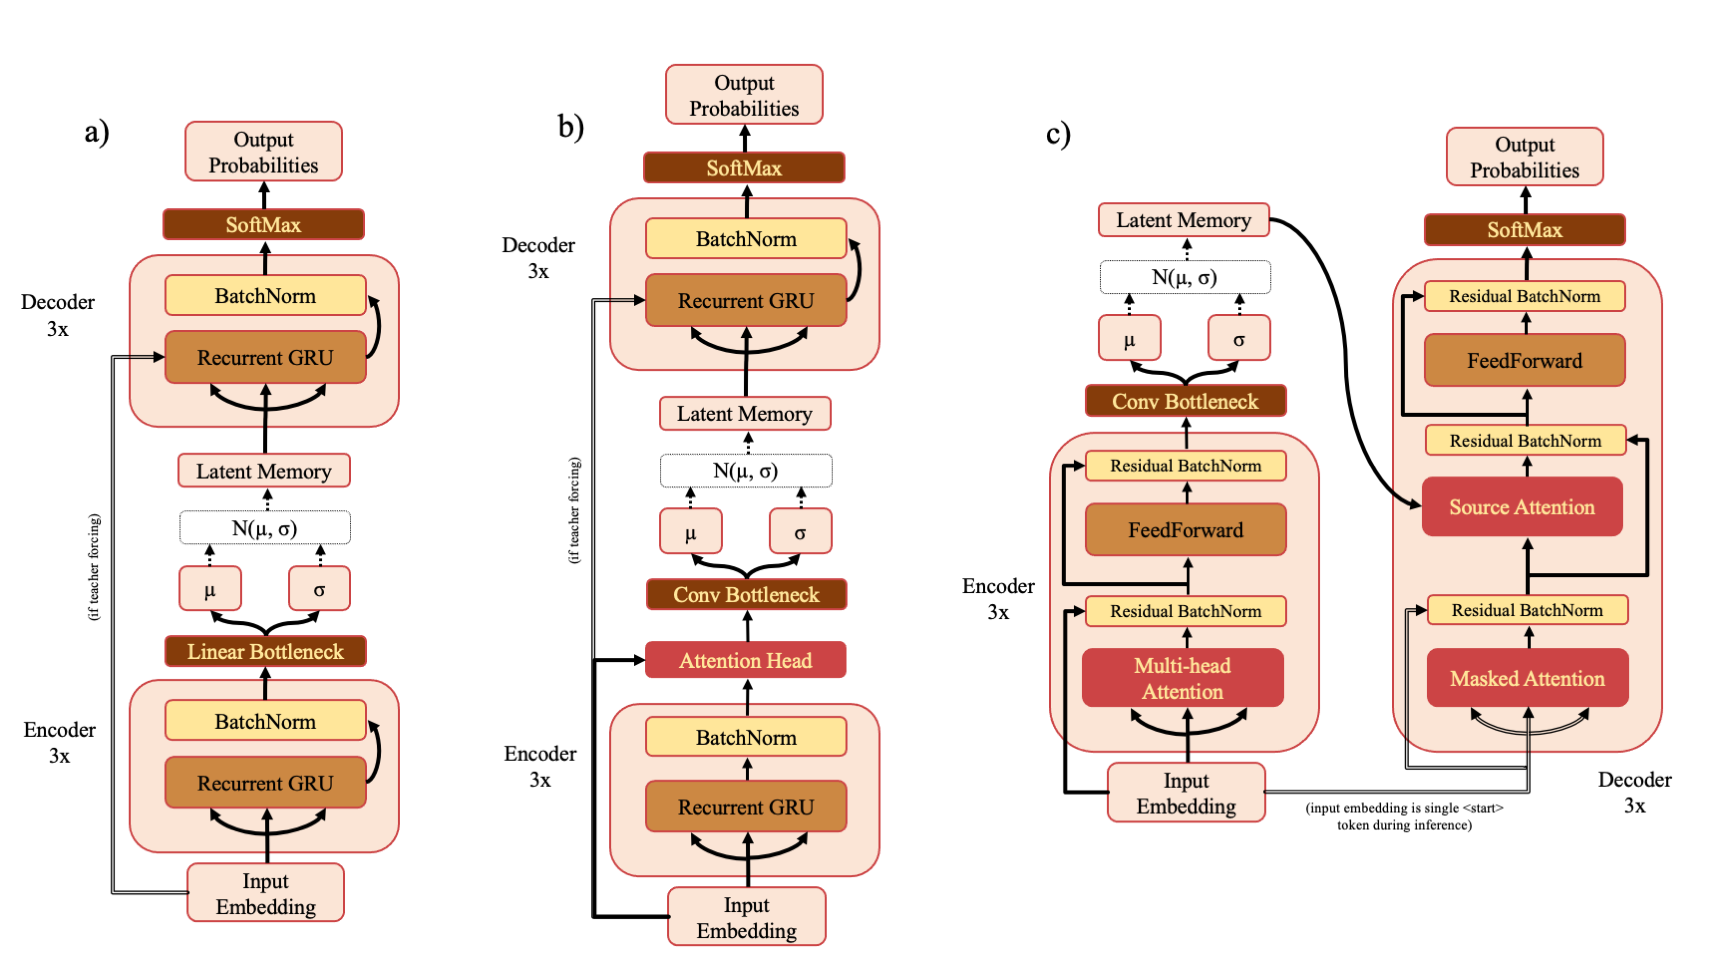

In [322]:
Image(filename='../../../publications/transvae/figs/fig3.png')

# Impact of Attention

### SMILES Length Distributions

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


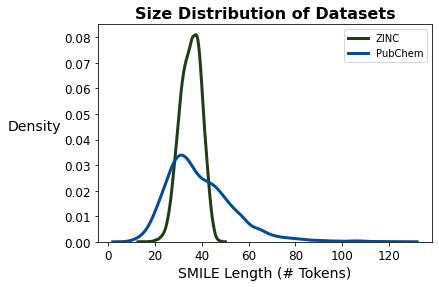

Avg. ZINC Length  - 35.36 tokens
Avg. PubChem Length  - 39.44 tokens


Max ZINC Length  - 48 tokens
Max PubChem Length  - 125 tokens


In [109]:
%matplotlib inline
zinc_smiles = pd.read_csv('../data/moses_2mil_dev.txt').sample(10000).to_numpy()[:,0]
pubc_smiles = pd.read_csv('../data/pubc_5mil_dev.txt').sample(10000).to_numpy()[:,0]

zinc_lens = []
for smi in zinc_smiles:
    smi = smi_tokenizer(smi)
    zinc_lens.append(len(smi))

pubc_lens = []
for smi in pubc_smiles:
    smi = smi_tokenizer(smi)
    pubc_lens.append(len(smi))

avg_zinc_len = np.mean(zinc_lens)
avg_pubc_len = np.mean(pubc_lens)
max_zinc_len = np.max(zinc_lens)
max_pubc_len = np.max(pubc_lens)
sns.distplot(zinc_lens, kde=True, hist=False, label='ZINC', color='#243C15', kde_kws=dict(linewidth=3))
sns.distplot(pubc_lens, kde=True, hist=False, label='PubChem', color='#014B9A', kde_kws=dict(linewidth=3))
plt.legend(loc='best')
plt.xlabel('SMILE Length (# Tokens)', fontsize=14)
plt.ylabel('Density', rotation=0, labelpad=30, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Size Distribution of Datasets', fontweight='bold', fontsize=16)
plt.show()

print('Avg. ZINC Length  - {} tokens'.format(round(avg_zinc_len, 2)))
print('Avg. PubChem Length  - {} tokens'.format(round(avg_pubc_len, 2)))
print('\n')
print('Max ZINC Length  - {} tokens'.format(round(max_zinc_len, 2)))
print('Max PubChem Length  - {} tokens'.format(round(max_pubc_len, 2)))

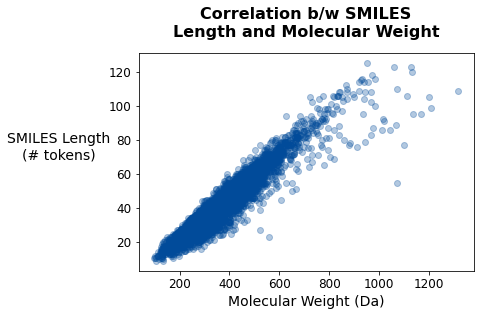

In [110]:
zinc_mwts = calc_MW(zinc_smiles)
pubc_mwts = calc_MW(pubc_smiles)
    
plt.scatter(pubc_mwts, pubc_lens, color='#014B9A', label='PubChem', alpha=0.3)
plt.xlabel('Molecular Weight (Da)', fontsize=14)
plt.ylabel('SMILES Length\n(# tokens)', rotation=0, labelpad=50, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Correlation b/w SMILES\nLength and Molecular Weight', fontweight='bold', fontsize=16, y=1.05)
plt.show()

In [98]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.array(pubc_mwts).reshape(-1,1), np.array(pubc_lens).reshape(-1,1))

max_len = 82
weight = (max_len - reg.intercept_) / reg.coef_
print('A SMILES string of length {} corresponds approximately to a molecule with MolWt of {}'.format(max_len,
                                                                                              round(weight[0][0], 2)))

A SMILES string of length 82 corresponds approximately to a molecule with MolWt of 703.87


### Reconstruction Accuracies

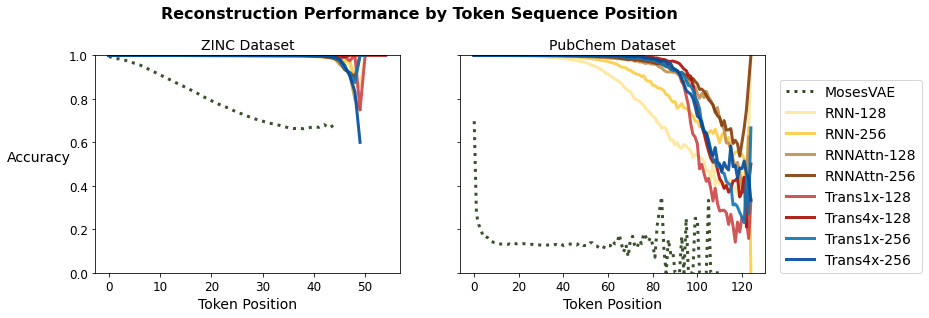

In [18]:
zinc_fns = ['../calcs/2milmoses_mogvae.json',
            '../calcs/latest_128_latent128_2milmoses_gruvae_v0.3.json',
            '../calcs/latest_256_latent128_2milmoses_gruvae_v0.3.json',
            '../calcs/latest_128_latent128_2milmoses_gruavae_v0.3.json',
            '../calcs/latest_256_latent128_2milmoses_gruavae_v0.3.json',
            '../calcs/latest_128_1x_latent128_2milmoses_tvae_v0.4.json',
            '../calcs/latest_128_4x_latent128_2milmoses_tvae_v0.4.json',
            '../calcs/latest_256_1x_latent128_2milmoses_tvae_v0.4.json',
            '../calcs/latest_256_4x_latent128_2milmoses_tvae_v0.4.json']

pubc_fns = ['../calcs/mogvae_pubc_090.json',
            '../calcs/060_128_latent128_5milpubc_gruvae_v0.3.json',
            '../calcs/060_256_latent128_5milpubc_gruvae_v0.3.json',
            '../calcs/060_128_latent128_5milpubc_gruavae_v0.3.json',
            '../calcs/060_256_latent128_5milpubc_gruavae_v0.3.json',
            '../calcs/060_128_1x_latent128_5milpubc_tvae_v0.4.json',
            '../calcs/060_128_4x_latent128_5milpubc_tvae_v0.4.json',
            '../calcs/060_256_1x_latent128_5milpubc_tvae_v0.4.json',
            '../calcs/060_256_4x_latent128_5milpubc_tvae_v0.4.json',]

labels = ['MosesVAE', 'RNN-128', 'RNN-256', 'RNNAttn-128',
          'RNNAttn-256', 'Trans1x-128', 'Trans4x-128',
          'Trans1x-256', 'Trans4x-256']

zinc_data = {}
for fn, label in zip(zinc_fns, labels):
    with open(fn, 'r') as f:
        dump = json.load(f)
    zinc_data[label] = dump

zinc_pos_accs = {}
for k, v in zinc_data.items():
    zinc_pos_accs[k] = v['accs']['test'][2]

pubc_data = {}
for fn, label in zip(pubc_fns, labels):
    with open(fn, 'r') as f:
        dump = json.load(f)
    pubc_data[label] = dump

pubc_pos_accs = {}
for k, v in pubc_data.items():
    pubc_pos_accs[k] = v['accs']['test'][2]

colors = ['#243C15', '#FFE69A', '#FBCE45','#C0904F', '#853C0A',
          '#CC4445', '#A70F08', '#0F75B7', '#014B9A']

fig, (a0, a1) = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for i, accs in enumerate(zinc_pos_accs.values()):
    if i == 0:
        ls = ':'
    else:
        ls = '-'
    a0.plot(accs, lw=3, color=colors[i], label=labels[i], alpha=0.9, ls=ls)
a0.set_xlabel('Token Position', fontsize=14)
a0.set_ylim([0,1])
a0.set_ylabel('Accuracy', rotation=0, labelpad=30, fontsize=14)
a0.set_title('ZINC Dataset', fontsize=14)
for tick in a0.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in a0.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for i, accs in enumerate(pubc_pos_accs.values()):
    if i == 0:
        ls = ':'
    else:
        ls = '-'
    a1.plot(accs, lw=3, color=colors[i], label=labels[i], alpha=0.9, ls=ls)
a1.set_xlabel('Token Position', fontsize=14)
a1.set_ylim([0,1])
a1.set_title('PubChem Dataset', fontsize=14)
for tick in a1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in a1.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.suptitle('Reconstruction Performance by Token Sequence Position', fontweight='bold', y=1.05, fontsize=16)
plt.legend(loc=(1.05, 0), fontsize=14)
plt.show()

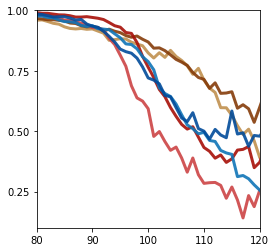

In [19]:
fig = plt.figure(figsize=(4,4))

for i, accs in enumerate(pubc_pos_accs.values()):
    if i in [0,1,2]:
        pass
    else:
        plt.plot(accs, lw=3, color=colors[i], label=labels[i], alpha=0.9)
plt.ylim([0.1,1])
plt.xlim([80,120])
plt.yticks([0.25,0.5,0.75,1.0])
plt.show()

In [91]:
for label in labels:
    for i, acc in enumerate(pubc_data[label]['accs']['test'][2]):
        if acc < 0.99:
            print('{} maintains > 99% accuracy for SMILES up to {} token(s)'.format(label, i+1))
            break

MosesVAE maintains > 99% accuracy for SMILES up to 1 token(s)
RNN-128 maintains > 99% accuracy for SMILES up to 36 token(s)
RNN-256 maintains > 99% accuracy for SMILES up to 50 token(s)
RNNAttn-128 maintains > 99% accuracy for SMILES up to 60 token(s)
RNNAttn-256 maintains > 99% accuracy for SMILES up to 64 token(s)
Trans1x-128 maintains > 99% accuracy for SMILES up to 75 token(s)
Trans4x-128 maintains > 99% accuracy for SMILES up to 82 token(s)
Trans1x-256 maintains > 99% accuracy for SMILES up to 70 token(s)
Trans4x-256 maintains > 99% accuracy for SMILES up to 77 token(s)


### Visualizing Attention

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from collections import defaultdict
import rdkit
print(rdkit.__version__)

2020.09.1


In [6]:
from tensor2tensor.visualization import attention

In [7]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [8]:
def align_smiles_w_mol(mol, smi):
    atom_chars = ['C', 'c', 'S', 'O', 'o', 'N', 'n', '[nH]', 'Cl', 'Br', 'F']
    smi = ['<bos>'] + smi_tokenizer(smi)
    molidx_2_smidx = {}
    at_names = []
    for at in mol.GetAtoms():
        at_names.append(at.GetSymbol())
    idx_tracker = 0
    for i, char in enumerate(smi):
        if char in atom_chars:
            molidx_2_smidx[i] = idx_tracker
            idx_tracker += 1
    return molidx_2_smidx, at_names

In [103]:
moses_train = pd.read_csv('../data/moses_2mil_train.txt').to_numpy()[:,0]
attn_wts = np.load('../attn_wts/256_latent128_2milmoses_gruavae_v0.3.npy')
self_wts_ = np.load('../attn_wts/256_4x_latent128_2milmoses_tvae_v0.4_self.npy')
src_wts_ = np.load('../attn_wts/256_4x_latent128_2milmoses_tvae_v0.4_src.npy')
attn_smiles = moses_train[:100000]

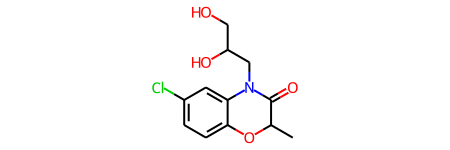

In [233]:
idx = 4
smi = attn_smiles[idx]
mol = Chem.MolFromSmiles(smi)
m_2_s, at_names = align_smiles_w_mol(mol, smi)
smi_toks = ['<bos>'] + smi_tokenizer(smi)
smi_label = smi_tokenizer(smi)
src = ['<bos>'] + smi_label
tgt = []
for i, tok in enumerate(src):
    tgt.append('{}_{}'.format(i, tok))
rnn_wts = attn_wts[idx,:len(smi_label),:len(smi_label)]
rnn_wts = [rnn_wts.reshape(1, 1, len(smi_label), len(smi_label))]
self_wt_ = self_wts_[idx,:,:,:len(src),:len(src)]
src_wt_ = src_wts_[idx,:,:,:len(src),:len(tgt)]
self_wts = []
src_wts = []
for i in range(self_wt_.shape[0]):
    self_wt = self_wt_[i,:,:,:]
    self_wts.append(self_wt)
for i in range(src_wt_.shape[0]):
    src_wt = src_wt_[i,:,:,:]
    src_wts.append(src_wt)
mol

In [142]:
# attention.show(src, tgt, self_wts, self_wts, self_wts)
# attention.show(smi_label, smi_label, rnn_wts, rnn_wts, rnn_wts)
None

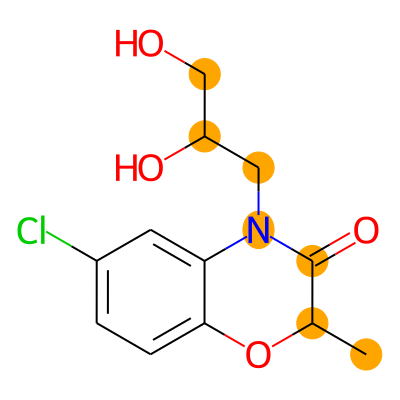

In [131]:
from matplotlib.colors import ColorConverter
save = False
attn_head = 1
atom_idx = 16
atom_wts = self_wts[0][attn_head,:,atom_idx]
hit_ats = np.where(atom_wts > 1e-5)[0]
# print(self_wts[0][0,attn_head,:,atom_idx])

color_names = ['blue', 'orange', 'green', 'red']
colors = []
for name in color_names:
    colors.append(ColorConverter().to_rgb(name))
athighlights = defaultdict(list)
arads = {}
for at in hit_ats:
    at = int(at)
    if at in m_2_s.keys():
        sat = m_2_s[at]
        color = list(colors[attn_head])
        color.append(atom_wts[at])
        athighlights[sat].append(colors[attn_head])
        arads[sat] = float(atom_wts[at]) / 4
    else:
        pass

d2d = rdMolDraw2D.MolDraw2DSVG(400,400)
d2d.DrawMoleculeWithHighlights(mol,'',dict(athighlights),{},arads,{})
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
if save:
    with open('../../..//publications/transvae/figs/attnhead{}.svg'.format(attn_head+1), 'w') as f:
        f.write(svg)
SVG(svg)

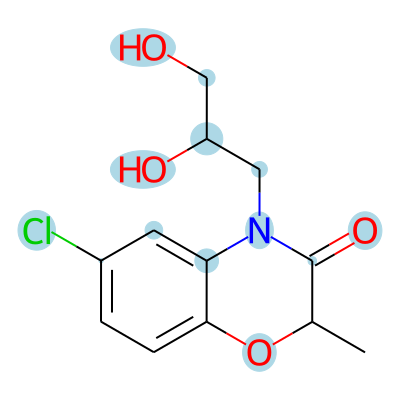

In [137]:
from matplotlib.colors import ColorConverter
save = False
attn_head = 0
atom_idx = 15
atom_wts = rnn_wts[0][0,attn_head,:,atom_idx]
hit_ats = np.where(atom_wts > 1e-5)[0] + 1
# print(self_wts[0][0,attn_head,:,atom_idx])

color_names = ['lightblue', 'orange', 'green', 'red']
colors = []
for name in color_names:
    colors.append(ColorConverter().to_rgb(name))
athighlights = defaultdict(list)
arads = {}
for at in hit_ats:
    at = int(at)
    if at in m_2_s.keys():
        sat = m_2_s[at]
        color = list(colors[attn_head])
        color.append(atom_wts[at-1])
        athighlights[sat].append(colors[attn_head])
        arads[sat] = float(atom_wts[at-1]) * 5
    else:
        pass

d2d = rdMolDraw2D.MolDraw2DSVG(400,400)
d2d.DrawMoleculeWithHighlights(mol,'',dict(athighlights),{},arads,{})
d2d.FinishDrawing()
svg = d2d.GetDrawingText()
if save:
    with open('../../..//publications/transvae/figs/rnnattnhead{}.svg'.format(attn_head+1), 'w') as f:
        f.write(svg)
SVG(svg)

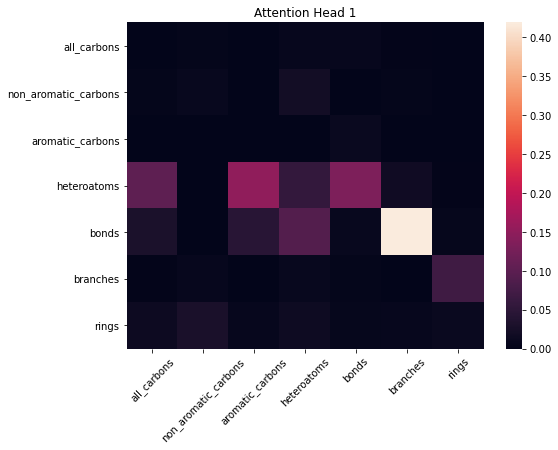

In [178]:
comparisons = ['all_carbons', 'non_aromatic_carbons', 'aromatic_carbons', 'heteroatoms', 'bonds', 'branches', 'rings']

comparisons_key = {'all_carbons': ['C', 'c'],
                   'non_aromatic_carbons': ['C'],
                   'aromatic_carbons': ['c'],
                   'heteroatoms': ['N', 'S', 'O', 'F', 'n', 's', 'Cl', 'Br', '[nH]', 'o'],
                   'bonds': ['-', '=', '#'],
                   'branches': ['(', ')'],
                   'rings': ['1', '2', '3', '4', '5', '6']
                  }

attn_weights_dict = {}
for k in comparisons:
    attn_weights_dict[k] = {}
for k in attn_weights_dict.keys():
    for k_prime in attn_weights_dict.keys():
        attn_weights_dict[k][k_prime] = []

attn_head = 0
for idx in range(5000):
    smi = attn_smiles[idx]
    mol = Chem.MolFromSmiles(smi)
    m_2_s, at_names = align_smiles_w_mol(mol, smi)
    smi_toks = ['<bos>'] + smi_tokenizer(smi)
    smi_label = smi_tokenizer(smi)
    src = ['<bos>'] + smi_label
    tgt = []
    for i, tok in enumerate(src):
        tgt.append('{}_{}'.format(i, tok))
    rnn_wts = attn_wts[idx,:len(smi_label),:len(smi_label)]
    rnn_wts = [rnn_wts.reshape(1, 1, len(smi_label), len(smi_label))]
    self_wt_ = self_wts_[idx,:,:,:len(src),:len(src)]
    src_wt_ = src_wts_[idx,:,:,:len(src),:len(tgt)]
    self_wts = []
    src_wts = []
    for i in range(self_wt_.shape[0]):
        self_wt = self_wt_[i,:,:,:]
        self_wts.append(self_wt)
    for i in range(src_wt_.shape[0]):
        src_wt = src_wt_[i,:,:,:]
        src_wts.append(src_wt)
    for atom_idx in range(len(smi_toks)):
        if atom_idx == 0:
            pass
        else:
            smi_tok = smi_toks[atom_idx]
            atom_wts = self_wts[0][attn_head,:,atom_idx]
            c_keys_1 = []
            for c_key_1, vals in comparisons_key.items():
                if smi_tok in vals:
                    c_keys_1.append(c_key_1)
            for j in range(atom_wts.shape[0]):
                if j == 0:
                    pass
                else:
                    attn_tok = smi_toks[j]
                    c_keys_2 = []
                    for c_key_2, vals in comparisons_key.items():
                        if attn_tok in vals:
                            c_keys_2.append(c_key_2)
                    for c_key_1 in c_keys_1:
                        for c_key_2 in c_keys_2:   
                            attn_weights_dict[c_key_1][c_key_2].append(atom_wts[j])

avg_attn_weights = np.zeros((len(attn_weights_dict.keys()), len(attn_weights_dict.keys())))
for i, smi_tok in enumerate(attn_weights_dict.keys()):
    for j, attn_tok in enumerate(attn_weights_dict.keys()):
        avg_attn_weight = np.mean(attn_weights_dict[smi_tok][attn_tok])
        if np.isnan(avg_attn_weight):
            avg_attn_weight = 0.0
        avg_attn_weights[i,j] = avg_attn_weight
heatmap_labels = list(attn_weights_dict.keys())

fig = plt.figure(figsize=(8,6))

sns.heatmap(avg_attn_weights)
plt.xticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=45)
plt.yticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=0)
plt.title('Attention Head {}'.format(attn_head+1))
plt.show()

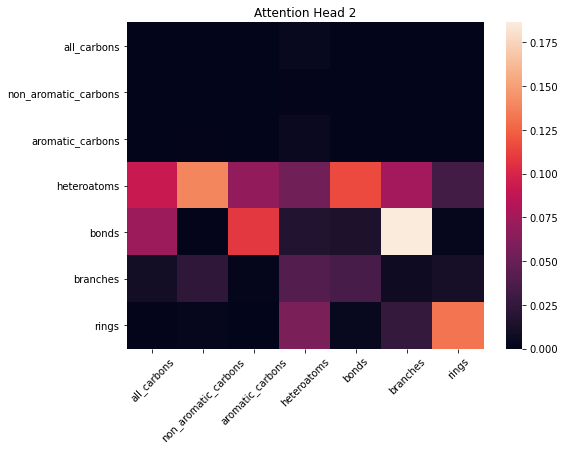

In [179]:
comparisons = ['all_carbons', 'non_aromatic_carbons', 'aromatic_carbons', 'heteroatoms', 'bonds', 'branches', 'rings']

comparisons_key = {'all_carbons': ['C', 'c'],
                   'non_aromatic_carbons': ['C'],
                   'aromatic_carbons': ['c'],
                   'heteroatoms': ['N', 'S', 'O', 'F', 'n', 's', 'Cl', 'Br', '[nH]', 'o'],
                   'bonds': ['-', '=', '#'],
                   'branches': ['(', ')'],
                   'rings': ['1', '2', '3', '4', '5', '6']
                  }

attn_weights_dict = {}
for k in comparisons:
    attn_weights_dict[k] = {}
for k in attn_weights_dict.keys():
    for k_prime in attn_weights_dict.keys():
        attn_weights_dict[k][k_prime] = []

attn_head = 1
for idx in range(5000):
    smi = attn_smiles[idx]
    mol = Chem.MolFromSmiles(smi)
    m_2_s, at_names = align_smiles_w_mol(mol, smi)
    smi_toks = ['<bos>'] + smi_tokenizer(smi)
    smi_label = smi_tokenizer(smi)
    src = ['<bos>'] + smi_label
    tgt = []
    for i, tok in enumerate(src):
        tgt.append('{}_{}'.format(i, tok))
    rnn_wts = attn_wts[idx,:len(smi_label),:len(smi_label)]
    rnn_wts = [rnn_wts.reshape(1, 1, len(smi_label), len(smi_label))]
    self_wt_ = self_wts_[idx,:,:,:len(src),:len(src)]
    src_wt_ = src_wts_[idx,:,:,:len(src),:len(tgt)]
    self_wts = []
    src_wts = []
    for i in range(self_wt_.shape[0]):
        self_wt = self_wt_[i,:,:,:]
        self_wts.append(self_wt)
    for i in range(src_wt_.shape[0]):
        src_wt = src_wt_[i,:,:,:]
        src_wts.append(src_wt)
    for atom_idx in range(len(smi_toks)):
        if atom_idx == 0:
            pass
        else:
            smi_tok = smi_toks[atom_idx]
            atom_wts = self_wts[0][attn_head,:,atom_idx]
            c_keys_1 = []
            for c_key_1, vals in comparisons_key.items():
                if smi_tok in vals:
                    c_keys_1.append(c_key_1)
            for j in range(atom_wts.shape[0]):
                if j == 0:
                    pass
                else:
                    attn_tok = smi_toks[j]
                    c_keys_2 = []
                    for c_key_2, vals in comparisons_key.items():
                        if attn_tok in vals:
                            c_keys_2.append(c_key_2)
                    for c_key_1 in c_keys_1:
                        for c_key_2 in c_keys_2:   
                            attn_weights_dict[c_key_1][c_key_2].append(atom_wts[j])

avg_attn_weights = np.zeros((len(attn_weights_dict.keys()), len(attn_weights_dict.keys())))
for i, smi_tok in enumerate(attn_weights_dict.keys()):
    for j, attn_tok in enumerate(attn_weights_dict.keys()):
        avg_attn_weight = np.mean(attn_weights_dict[smi_tok][attn_tok])
        if np.isnan(avg_attn_weight):
            avg_attn_weight = 0.0
        avg_attn_weights[i,j] = avg_attn_weight
heatmap_labels = list(attn_weights_dict.keys())

fig = plt.figure(figsize=(8,6))

sns.heatmap(avg_attn_weights)
plt.xticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=45)
plt.yticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=0)
plt.title('Attention Head {}'.format(attn_head+1))
plt.show()

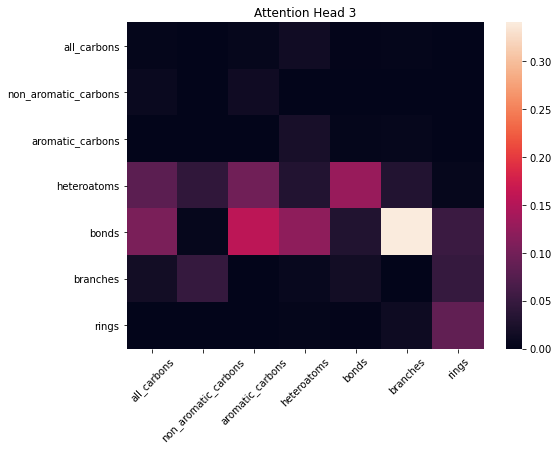

In [180]:
comparisons = ['all_carbons', 'non_aromatic_carbons', 'aromatic_carbons', 'heteroatoms', 'bonds', 'branches', 'rings']

comparisons_key = {'all_carbons': ['C', 'c'],
                   'non_aromatic_carbons': ['C'],
                   'aromatic_carbons': ['c'],
                   'heteroatoms': ['N', 'S', 'O', 'F', 'n', 's', 'Cl', 'Br', '[nH]', 'o'],
                   'bonds': ['-', '=', '#'],
                   'branches': ['(', ')'],
                   'rings': ['1', '2', '3', '4', '5', '6']
                  }

attn_weights_dict = {}
for k in comparisons:
    attn_weights_dict[k] = {}
for k in attn_weights_dict.keys():
    for k_prime in attn_weights_dict.keys():
        attn_weights_dict[k][k_prime] = []

attn_head = 2
for idx in range(5000):
    smi = attn_smiles[idx]
    mol = Chem.MolFromSmiles(smi)
    m_2_s, at_names = align_smiles_w_mol(mol, smi)
    smi_toks = ['<bos>'] + smi_tokenizer(smi)
    smi_label = smi_tokenizer(smi)
    src = ['<bos>'] + smi_label
    tgt = []
    for i, tok in enumerate(src):
        tgt.append('{}_{}'.format(i, tok))
    rnn_wts = attn_wts[idx,:len(smi_label),:len(smi_label)]
    rnn_wts = [rnn_wts.reshape(1, 1, len(smi_label), len(smi_label))]
    self_wt_ = self_wts_[idx,:,:,:len(src),:len(src)]
    src_wt_ = src_wts_[idx,:,:,:len(src),:len(tgt)]
    self_wts = []
    src_wts = []
    for i in range(self_wt_.shape[0]):
        self_wt = self_wt_[i,:,:,:]
        self_wts.append(self_wt)
    for i in range(src_wt_.shape[0]):
        src_wt = src_wt_[i,:,:,:]
        src_wts.append(src_wt)
    for atom_idx in range(len(smi_toks)):
        if atom_idx == 0:
            pass
        else:
            smi_tok = smi_toks[atom_idx]
            atom_wts = self_wts[0][attn_head,:,atom_idx]
            c_keys_1 = []
            for c_key_1, vals in comparisons_key.items():
                if smi_tok in vals:
                    c_keys_1.append(c_key_1)
            for j in range(atom_wts.shape[0]):
                if j == 0:
                    pass
                else:
                    attn_tok = smi_toks[j]
                    c_keys_2 = []
                    for c_key_2, vals in comparisons_key.items():
                        if attn_tok in vals:
                            c_keys_2.append(c_key_2)
                    for c_key_1 in c_keys_1:
                        for c_key_2 in c_keys_2:   
                            attn_weights_dict[c_key_1][c_key_2].append(atom_wts[j])

avg_attn_weights = np.zeros((len(attn_weights_dict.keys()), len(attn_weights_dict.keys())))
for i, smi_tok in enumerate(attn_weights_dict.keys()):
    for j, attn_tok in enumerate(attn_weights_dict.keys()):
        avg_attn_weight = np.mean(attn_weights_dict[smi_tok][attn_tok])
        if np.isnan(avg_attn_weight):
            avg_attn_weight = 0.0
        avg_attn_weights[i,j] = avg_attn_weight
heatmap_labels = list(attn_weights_dict.keys())

fig = plt.figure(figsize=(8,6))

sns.heatmap(avg_attn_weights)
plt.xticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=45)
plt.yticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=0)
plt.title('Attention Head {}'.format(attn_head+1))
plt.show()

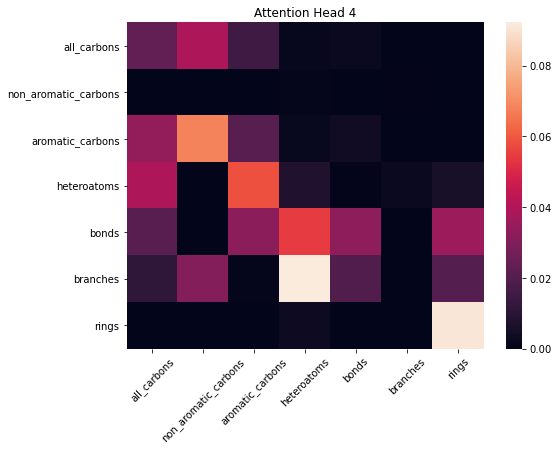

In [181]:
comparisons = ['all_carbons', 'non_aromatic_carbons', 'aromatic_carbons', 'heteroatoms', 'bonds', 'branches', 'rings']

comparisons_key = {'all_carbons': ['C', 'c'],
                   'non_aromatic_carbons': ['C'],
                   'aromatic_carbons': ['c'],
                   'heteroatoms': ['N', 'S', 'O', 'F', 'n', 's', 'Cl', 'Br', '[nH]', 'o'],
                   'bonds': ['-', '=', '#'],
                   'branches': ['(', ')'],
                   'rings': ['1', '2', '3', '4', '5', '6']
                  }

attn_weights_dict = {}
for k in comparisons:
    attn_weights_dict[k] = {}
for k in attn_weights_dict.keys():
    for k_prime in attn_weights_dict.keys():
        attn_weights_dict[k][k_prime] = []

attn_head = 3
for idx in range(5000):
    smi = attn_smiles[idx]
    mol = Chem.MolFromSmiles(smi)
    m_2_s, at_names = align_smiles_w_mol(mol, smi)
    smi_toks = ['<bos>'] + smi_tokenizer(smi)
    smi_label = smi_tokenizer(smi)
    src = ['<bos>'] + smi_label
    tgt = []
    for i, tok in enumerate(src):
        tgt.append('{}_{}'.format(i, tok))
    rnn_wts = attn_wts[idx,:len(smi_label),:len(smi_label)]
    rnn_wts = [rnn_wts.reshape(1, 1, len(smi_label), len(smi_label))]
    self_wt_ = self_wts_[idx,:,:,:len(src),:len(src)]
    src_wt_ = src_wts_[idx,:,:,:len(src),:len(tgt)]
    self_wts = []
    src_wts = []
    for i in range(self_wt_.shape[0]):
        self_wt = self_wt_[i,:,:,:]
        self_wts.append(self_wt)
    for i in range(src_wt_.shape[0]):
        src_wt = src_wt_[i,:,:,:]
        src_wts.append(src_wt)
    for atom_idx in range(len(smi_toks)):
        if atom_idx == 0:
            pass
        else:
            smi_tok = smi_toks[atom_idx]
            atom_wts = self_wts[0][attn_head,:,atom_idx]
            c_keys_1 = []
            for c_key_1, vals in comparisons_key.items():
                if smi_tok in vals:
                    c_keys_1.append(c_key_1)
            for j in range(atom_wts.shape[0]):
                if j == 0:
                    pass
                else:
                    attn_tok = smi_toks[j]
                    c_keys_2 = []
                    for c_key_2, vals in comparisons_key.items():
                        if attn_tok in vals:
                            c_keys_2.append(c_key_2)
                    for c_key_1 in c_keys_1:
                        for c_key_2 in c_keys_2:   
                            attn_weights_dict[c_key_1][c_key_2].append(atom_wts[j])

avg_attn_weights = np.zeros((len(attn_weights_dict.keys()), len(attn_weights_dict.keys())))
for i, smi_tok in enumerate(attn_weights_dict.keys()):
    for j, attn_tok in enumerate(attn_weights_dict.keys()):
        avg_attn_weight = np.mean(attn_weights_dict[smi_tok][attn_tok])
        if np.isnan(avg_attn_weight):
            avg_attn_weight = 0.0
        avg_attn_weights[i,j] = avg_attn_weight
heatmap_labels = list(attn_weights_dict.keys())

fig = plt.figure(figsize=(8,6))

sns.heatmap(avg_attn_weights)
plt.xticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=45)
plt.yticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=0)
plt.title('Attention Head {}'.format(attn_head+1))
plt.show()

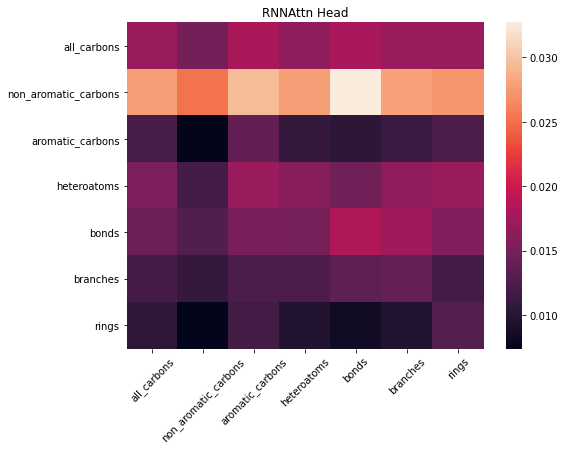

In [183]:
comparisons = ['all_carbons', 'non_aromatic_carbons', 'aromatic_carbons', 'heteroatoms', 'bonds', 'branches', 'rings']

comparisons_key = {'all_carbons': ['C', 'c'],
                   'non_aromatic_carbons': ['C'],
                   'aromatic_carbons': ['c'],
                   'heteroatoms': ['N', 'S', 'O', 'F', 'n', 's', 'Cl', 'Br', '[nH]', 'o'],
                   'bonds': ['-', '=', '#'],
                   'branches': ['(', ')'],
                   'rings': ['1', '2', '3', '4', '5', '6']
                  }

attn_weights_dict = {}
for k in comparisons:
    attn_weights_dict[k] = {}
for k in attn_weights_dict.keys():
    for k_prime in attn_weights_dict.keys():
        attn_weights_dict[k][k_prime] = []

attn_head = 0
for idx in range(5000):
    smi = attn_smiles[idx]
    mol = Chem.MolFromSmiles(smi)
    m_2_s, at_names = align_smiles_w_mol(mol, smi)
    smi_toks = ['<bos>'] + smi_tokenizer(smi)
    smi_label = smi_tokenizer(smi)
    src = ['<bos>'] + smi_label
    tgt = []
    for i, tok in enumerate(src):
        tgt.append('{}_{}'.format(i, tok))
    rnn_wts = attn_wts[idx,:len(smi_label),:len(smi_label)]
    rnn_wts = [rnn_wts.reshape(1, 1, len(smi_label), len(smi_label))]
    self_wt_ = self_wts_[idx,:,:,:len(src),:len(src)]
    src_wt_ = src_wts_[idx,:,:,:len(src),:len(tgt)]
    self_wts = []
    src_wts = []
    for i in range(self_wt_.shape[0]):
        self_wt = self_wt_[i,:,:,:]
        self_wts.append(self_wt)
    for i in range(src_wt_.shape[0]):
        src_wt = src_wt_[i,:,:,:]
        src_wts.append(src_wt)
    for atom_idx in range(len(smi_toks)):
        if atom_idx == 0:
            pass
        else:
            smi_tok = smi_toks[atom_idx]
            atom_wts = rnn_wts[0][0,attn_head,:,atom_idx-1]
            c_keys_1 = []
            for c_key_1, vals in comparisons_key.items():
                if smi_tok in vals:
                    c_keys_1.append(c_key_1)
            for j in range(atom_wts.shape[0]):
                attn_tok = smi_toks[j+1]
                c_keys_2 = []
                for c_key_2, vals in comparisons_key.items():
                    if attn_tok in vals:
                        c_keys_2.append(c_key_2)
                for c_key_1 in c_keys_1:
                    for c_key_2 in c_keys_2:   
                        attn_weights_dict[c_key_1][c_key_2].append(atom_wts[j])

avg_attn_weights = np.zeros((len(attn_weights_dict.keys()), len(attn_weights_dict.keys())))
for i, smi_tok in enumerate(attn_weights_dict.keys()):
    for j, attn_tok in enumerate(attn_weights_dict.keys()):
        avg_attn_weight = np.mean(attn_weights_dict[smi_tok][attn_tok])
        if np.isnan(avg_attn_weight):
            avg_attn_weight = 0.0
        avg_attn_weights[i,j] = avg_attn_weight
heatmap_labels = list(attn_weights_dict.keys())

fig = plt.figure(figsize=(8,6))

sns.heatmap(avg_attn_weights)
plt.xticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=45)
plt.yticks(np.arange(len(heatmap_labels))+0.5, heatmap_labels, rotation=0)
plt.title('RNNAttn Head')
plt.show()

# Information Entropy of Model Memory

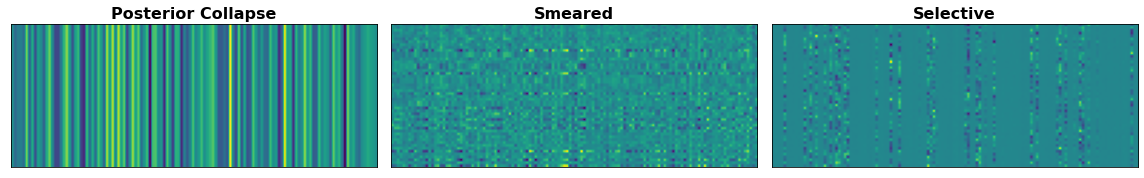

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(16,24))

smeared = np.load('../fig_data/2milmoses_mogvae_090_mus.npy')
selective = np.load('../fig_data/090_256_latent128_2milmoses_gruavae_v0.3_50mus.npy')
posterior_collapse = np.load('../fig_data/v0.2/rnn128_2milmoses_50mems.npy')
mems = [posterior_collapse, smeared, selective]

labels = ['Posterior Collapse', 'Smeared', 'Selective']
for i, ax in enumerate(fig.axes):
    ax.imshow(mems[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[i], fontweight='bold', fontsize=16)
fig.tight_layout()
plt.show()

In [4]:
mogvae_010_mus = np.load('../memory/2milmoses_mogvae_010_mus.npy')
mogvae_020_mus = np.load('../memory/2milmoses_mogvae_020_mus.npy')
mogvae_030_mus = np.load('../memory/2milmoses_mogvae_030_mus.npy')
mogvae_040_mus = np.load('../memory/2milmoses_mogvae_040_mus.npy')
mogvae_050_mus = np.load('../memory/2milmoses_mogvae_050_mus.npy')
mogvae_060_mus = np.load('../memory/2milmoses_mogvae_060_mus.npy')
mogvae_070_mus = np.load('../memory/2milmoses_mogvae_070_mus.npy')
mogvae_080_mus = np.load('../memory/2milmoses_mogvae_080_mus.npy')
mogvae_090_mus = np.load('../memory/2milmoses_mogvae_090_mus.npy')

mogvae_010_entropy = calc_entropy(mogvae_010_mus)
mogvae_020_entropy = calc_entropy(mogvae_020_mus)
mogvae_030_entropy = calc_entropy(mogvae_030_mus)
mogvae_040_entropy = calc_entropy(mogvae_040_mus)
mogvae_050_entropy = calc_entropy(mogvae_050_mus)
mogvae_060_entropy = calc_entropy(mogvae_060_mus)
mogvae_070_entropy = calc_entropy(mogvae_070_mus)
mogvae_080_entropy = calc_entropy(mogvae_080_mus)
mogvae_090_entropy = calc_entropy(mogvae_090_mus)

mogvae_entropy = [np.sum(mogvae_010_entropy), np.sum(mogvae_020_entropy), np.sum(mogvae_030_entropy), 
                  np.sum(mogvae_040_entropy), np.sum(mogvae_050_entropy), np.sum(mogvae_060_entropy), 
                  np.sum(mogvae_070_entropy), np.sum(mogvae_080_entropy), np.sum(mogvae_090_entropy)]

In [5]:
n_meaningful_dimensions = []
all_mogvae_entropies = [mogvae_010_entropy, mogvae_020_entropy, mogvae_030_entropy, mogvae_040_entropy,
                        mogvae_050_entropy, mogvae_060_entropy, mogvae_070_entropy, mogvae_080_entropy,
                        mogvae_090_entropy]
for e in all_mogvae_entropies:
    avg_e = np.mean(e)
    std_e = np.std(e)
    count = 0
    for entry in e:
        if entry > avg_e + std_e:
            count += 1
        else:
            pass
    n_meaningful_dimensions.append(count)
n_meaningful_dimensions.append(None)

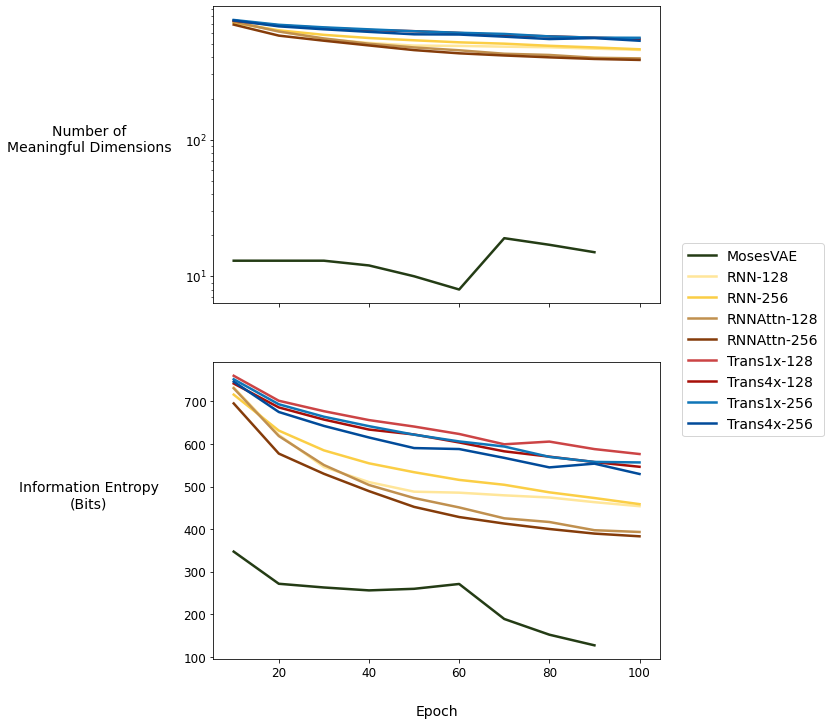

In [26]:
colors = ['#243C15', '#FFE69A', '#FBCE45','#C0904F', '#853C0A',
          '#CC4445', '#A70F08', '#0F75B7', '#014B9A']

fns = ['128_latent128_2milmoses_gruvae_v0.3.npy',
       '256_latent128_2milmoses_gruvae_v0.3.npy', 
       '128_latent128_2milmoses_gruavae_v0.3.npy',
       '256_latent128_2milmoses_gruavae_v0.3.npy',
       '128_1x_latent128_2milmoses_tvae_v0.4.npy',
       '128_4x_latent128_2milmoses_tvae_v0.4.npy',
       '256_1x_latent128_2milmoses_tvae_v0.4.npy',
       '256_4x_latent128_2milmoses_tvae_v0.4.npy']

labels = ['MosesVAE', 'RNN-128', 'RNN-256', 'RNNAttn-128',
          'RNNAttn-256', 'Trans1x-128', 'Trans4x-128',
          'Trans1x-256', 'Trans4x-256']
epochs = np.linspace(10, 100, 10)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8,12), sharex=True)

ax0.plot(epochs, n_meaningful_dimensions, c=colors[0], lw='2.5')
for i, fn in enumerate(fns):
    if fn == '128_1x_latent128_2milmoses_tvae_v0.4.npy':
        pass
    else:
        fn = fn.split('.npy')[0] + '_meaningful_dims.npy'
        n_dims = np.load('../entropy/{}'.format(fn))
        ax0.plot(epochs, n_dims, lw='2.5', c=colors[i+1])
ax0.set_ylabel('Number of\nMeaningful Dimensions', rotation=0, labelpad=95, fontsize=14)
ax0.set_yscale('log')
for tick in ax0.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax0.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
ax1.plot(epochs[:-1], mogvae_entropy, lw='2.5', c=colors[0], label=labels[0])
for i, (fn, label) in enumerate(zip(fns, labels)):
    model_entropy = np.load('../entropy/{}'.format(fn))
    ax1.plot(epochs, model_entropy, lw='2.5', c=colors[i+1], label=labels[i+1])
ax1.set_ylabel('Information Entropy\n(Bits)', rotation=0, labelpad=95, fontsize=14)
ax1.set_xlabel('Epoch', fontsize=14, labelpad=25)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.legend(loc=[1.05,0.75], fontsize=14)
plt.show()

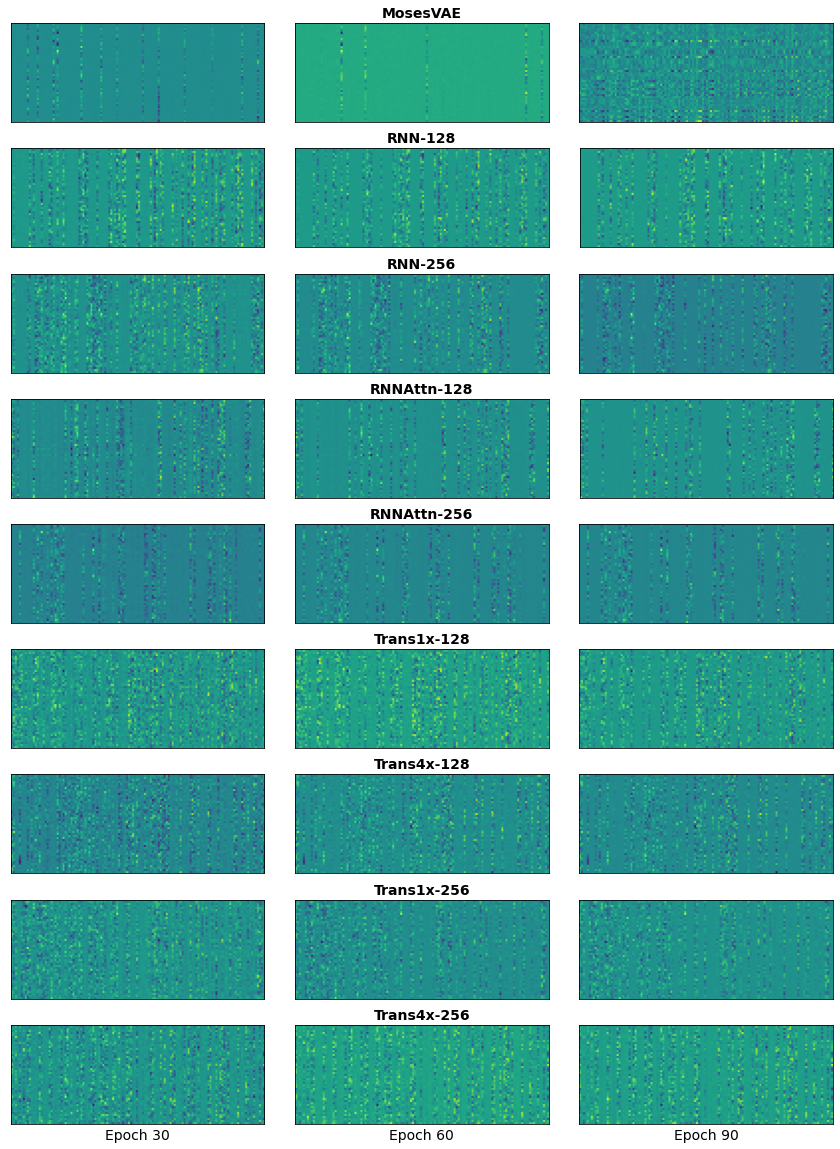

In [113]:
# mems calculated from smiles in legacy_models/moses/data/latent_test_smiles.csv (2milmoses test set)

vae_names = ['MosesVAE', 'MosesVAE', 'MosesVAE',
             'RNN-128', 'RNN-128', 'RNN-128', 
             'RNN-256', 'RNN-256', 'RNN-256',
             'RNNAttn-128', 'RNNAttn-128', 'RNNAttn-128', 
             'RNNAttn-256', 'RNNAttn-256', 'RNNAttn-256', 
             'Trans1x-128', 'Trans1x-128', 'Trans1x-128',
             'Trans4x-128', 'Trans4x-128', 'Trans4x-128',
             'Trans1x-256', 'Trans1x-256', 'Trans1x-256', 
             'Trans4x-256', 'Trans4x-256', 'Trans4x-256']
#              'Trans4x-128 (beta = 0.15)', 'Trans4x-128 (beta = 0.15)', 'Trans4x-128 (beta = 0.15)',
#              'Trans4x-128 (beta = 0.25)', 'Trans4x-128 (beta = 0.25)', 'Trans4x-128 (beta = 0.25)',
#              'Trans4x-128 (beta = 0.5)', 'Trans4x-128 (beta = 0.5)', 'Trans4x-128 (beta = 0.5)']
save_names = ['../fig_data/2milmoses_mogvae_030_mus.npy',
              '../fig_data/2milmoses_mogvae_060_mus.npy',
              '../fig_data/2milmoses_mogvae_090_mus.npy',
              '../fig_data/030_128_latent128_2milmoses_gruvae_v0.3_50mus.npy',
              '../fig_data/060_128_latent128_2milmoses_gruvae_v0.3_50mus.npy',
              '../fig_data/090_128_latent128_2milmoses_gruvae_v0.3_50mus.npy',
              '../fig_data/030_256_latent128_2milmoses_gruvae_v0.3_50mus.npy',
              '../fig_data/060_256_latent128_2milmoses_gruvae_v0.3_50mus.npy',
              '../fig_data/090_256_latent128_2milmoses_gruvae_v0.3_50mus.npy',
              '../fig_data/030_128_latent128_2milmoses_gruavae_v0.3_50mus.npy',
              '../fig_data/060_128_latent128_2milmoses_gruavae_v0.3_50mus.npy',
              '../fig_data/090_128_latent128_2milmoses_gruavae_v0.3_50mus.npy',
              '../fig_data/030_256_latent128_2milmoses_gruavae_v0.3_50mus.npy',
              '../fig_data/060_256_latent128_2milmoses_gruavae_v0.3_50mus.npy',
              '../fig_data/090_256_latent128_2milmoses_gruavae_v0.3_50mus.npy',
              '../fig_data/030_128_1x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/060_128_1x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/090_128_1x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/030_128_4x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/060_128_4x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/090_128_4x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/030_256_1x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/060_256_1x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/090_256_1x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/030_256_4x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/060_256_4x_latent128_2milmoses_tvae_v0.4_50mus.npy',
              '../fig_data/090_256_4x_latent128_2milmoses_tvae_v0.4_50mus.npy']
#               '../fig_data/030_128_4x_latent128_2milmoses_tvae_v0.4_beta0.15_50mus.npy',
#               '../fig_data/060_128_4x_latent128_2milmoses_tvae_v0.4_beta0.15_50mus.npy',
#               '../fig_data/090_128_4x_latent128_2milmoses_tvae_v0.4_beta0.15_50mus.npy',
#               '../fig_data/030_128_4x_latent128_2milmoses_tvae_v0.4_beta0.25_50mus.npy',
#               '../fig_data/060_128_4x_latent128_2milmoses_tvae_v0.4_beta0.25_50mus.npy',
#               '../fig_data/090_128_4x_latent128_2milmoses_tvae_v0.4_beta0.25_50mus.npy',
#               '../fig_data/030_128_4x_latent128_2milmoses_tvae_v0.4_beta0.5_50mus.npy',
#               '../fig_data/060_128_4x_latent128_2milmoses_tvae_v0.4_beta0.5_50mus.npy',
#               '../fig_data/090_128_4x_latent128_2milmoses_tvae_v0.4_beta0.5_50mus.npy']
                                                        
fig, axs = plt.subplots(9, 3, figsize=(12,16))

for i, ax in enumerate(fig.axes):
    if i % 3 == 1:
        ax.set_title(vae_names[i], fontweight='bold', fontsize=14)
    if i == 24:
        ax.set_xlabel('Epoch 30', fontsize=14)
    if i == 25:
        ax.set_xlabel('Epoch 60', fontsize=14)
    if i == 26:
        ax.set_xlabel('Epoch 90', fontsize=14)
    mem = np.load(save_names[i])
    ax.imshow(mem)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

# Strategies for Exploring Chemical Phase Space

### Validity vs. Exploration Tradeoff

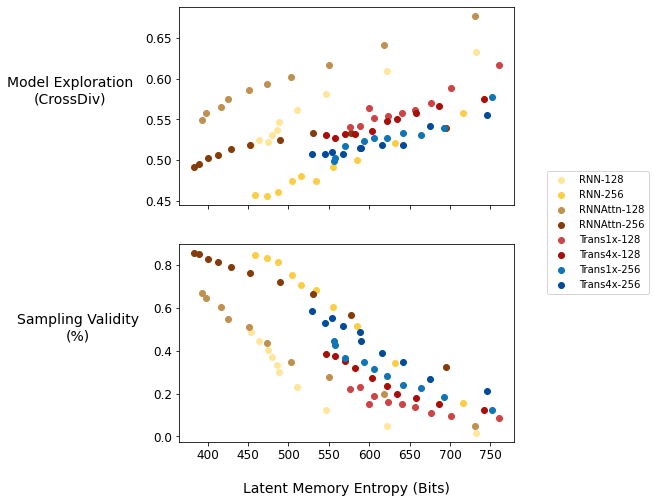

In [57]:
fns = ['128_latent128_2milmoses_gruvae_v0.3.npy',
       '256_latent128_2milmoses_gruvae_v0.3.npy', 
       '128_latent128_2milmoses_gruavae_v0.3.npy',
       '256_latent128_2milmoses_gruavae_v0.3.npy',
       '128_1x_latent128_2milmoses_tvae_v0.4.npy',
       '128_4x_latent128_2milmoses_tvae_v0.4.npy',
       '256_1x_latent128_2milmoses_tvae_v0.4.npy',
       '256_4x_latent128_2milmoses_tvae_v0.4.npy']

labels = ['RNN-128', 'RNN-256', 'RNNAttn-128', 'RNNAttn-256',
          'Trans1x-128', 'Trans4x-128', 'Trans1x-256', 'Trans4x-256']

colors = ['#FFE69A', '#FBCE45','#C0904F', '#853C0A',
          '#CC4445', '#A70F08', '#0F75B7', '#014B9A']

entropy_dict = {}
for i, (fn, label) in enumerate(zip(fns, labels)):
    entropy_dict[label] = np.load('../entropy/{}'.format(fn))

creativity_dict = {}
for i, model_fn in enumerate(model_fns):
    creativity_dict[labels[i]] = data_dict[model_fn+'_high_entropy']['crossdiv_train']

valid_dict = {}
for i, model_fn in enumerate(model_fns):
    valid_dict[labels[i]] = data_dict[model_fn+'_high_entropy']['valid_filter']
    
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))

for i, label in enumerate(labels):
    creativity_data = creativity_dict[label]
    entropy_data = entropy_dict[label]
    valid_data = valid_dict[label]
    axs[0].scatter(entropy_data, creativity_data, label=label, color=colors[i])
    axs[1].scatter(entropy_data, valid_data, label=label, color=colors[i])
axs[1].set_xlabel('Latent Memory Entropy (Bits)', fontsize=14, labelpad=20)
axs[0].set_ylabel('Model Exploration\n(CrossDiv)', rotation=0, labelpad=75, fontsize=14)
axs[1].set_ylabel('Sampling Validity\n(%)', rotation=0, labelpad=75, fontsize=14)
for tick in axs[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in axs[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in axs[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in axs[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.legend(loc=(1.1, 0.75))
plt.show()

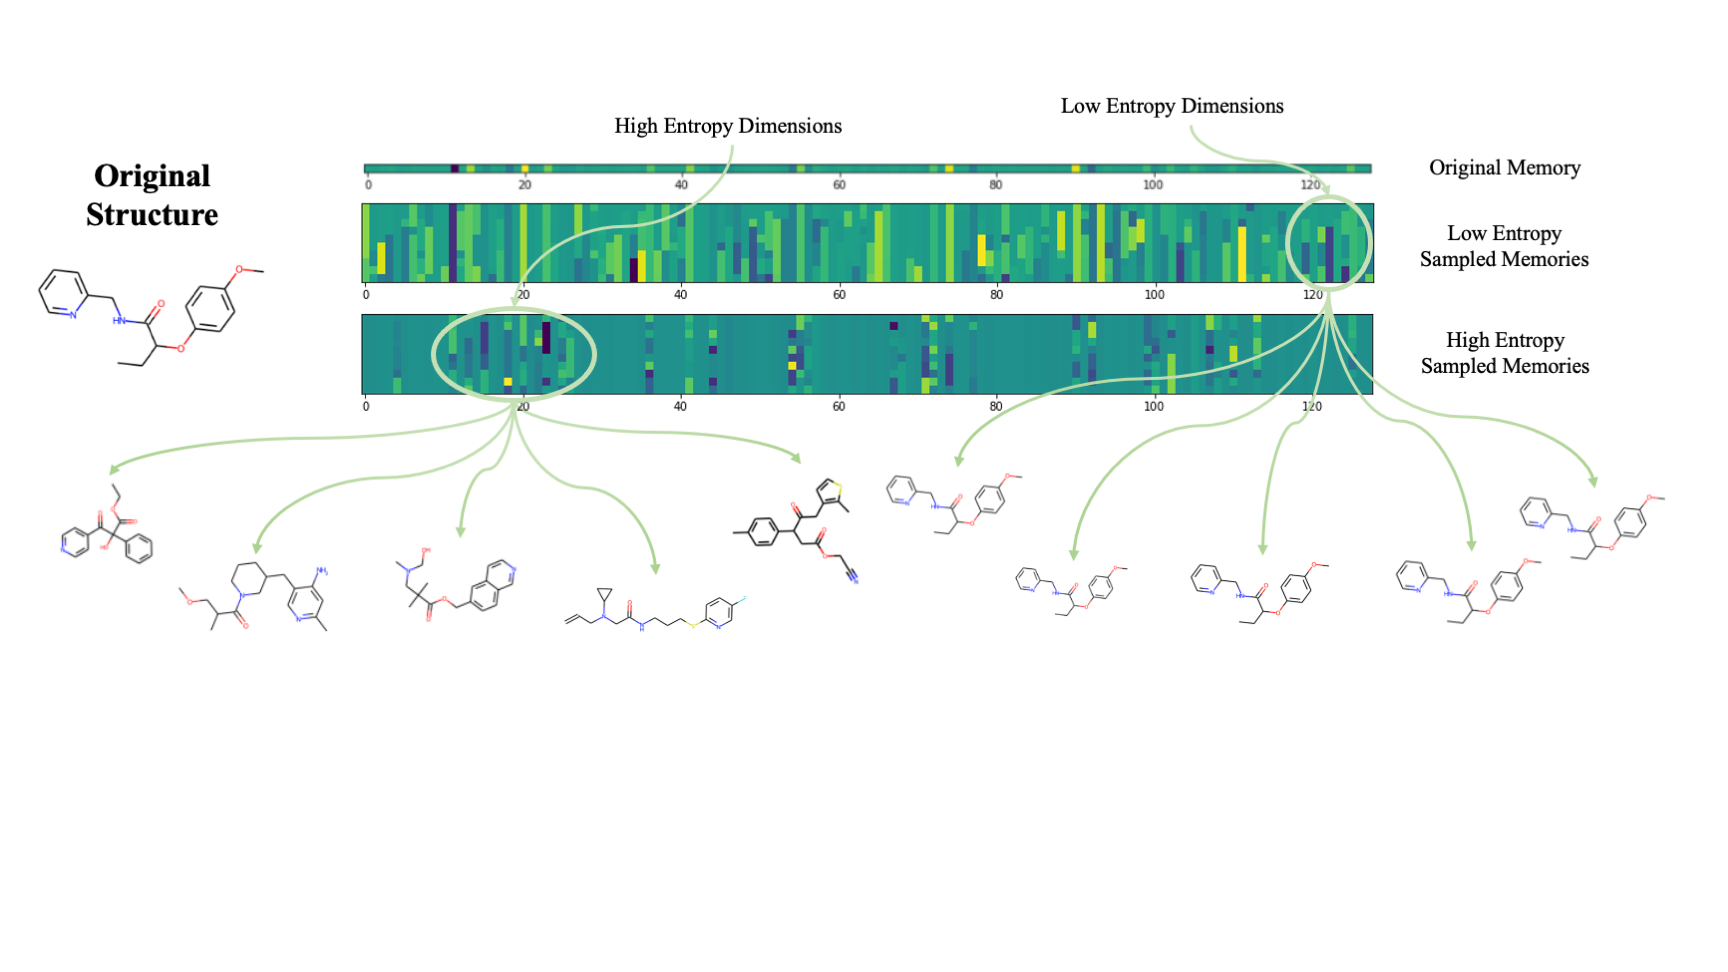

In [69]:
Image(filename='../../../publications/transvae/figs/fig9.png')

128_latent128_2milmoses_gruvae_v0.3 0.47546666666666665
256_latent128_2milmoses_gruvae_v0.3 0.8459
128_latent128_2milmoses_gruavae_v0.3 0.6717666666666666
256_latent128_2milmoses_gruavae_v0.3 0.8510666666666666
128_1x_latent128_2milmoses_tvae_v0.4 0.227
128_4x_latent128_2milmoses_tvae_v0.4 0.36533333333333334
256_1x_latent128_2milmoses_tvae_v0.4 0.4242
256_4x_latent128_2milmoses_tvae_v0.4 0.5667333333333333
128_latent128_2milmoses_gruvae_v0.3 0.6892666666666667
256_latent128_2milmoses_gruvae_v0.3 0.9182333333333333
128_latent128_2milmoses_gruavae_v0.3 0.7551
256_latent128_2milmoses_gruavae_v0.3 0.9293666666666667
128_1x_latent128_2milmoses_tvae_v0.4 0.3299
128_4x_latent128_2milmoses_tvae_v0.4 0.5581333333333334
256_1x_latent128_2milmoses_tvae_v0.4 0.5977333333333333
256_4x_latent128_2milmoses_tvae_v0.4 0.7518
128_latent128_2milmoses_gruvae_v0.3 0.5163905676339392
256_latent128_2milmoses_gruvae_v0.3 0.45890967623189294
128_latent128_2milmoses_gruavae_v0.3 0.5481403562291693
256_latent12

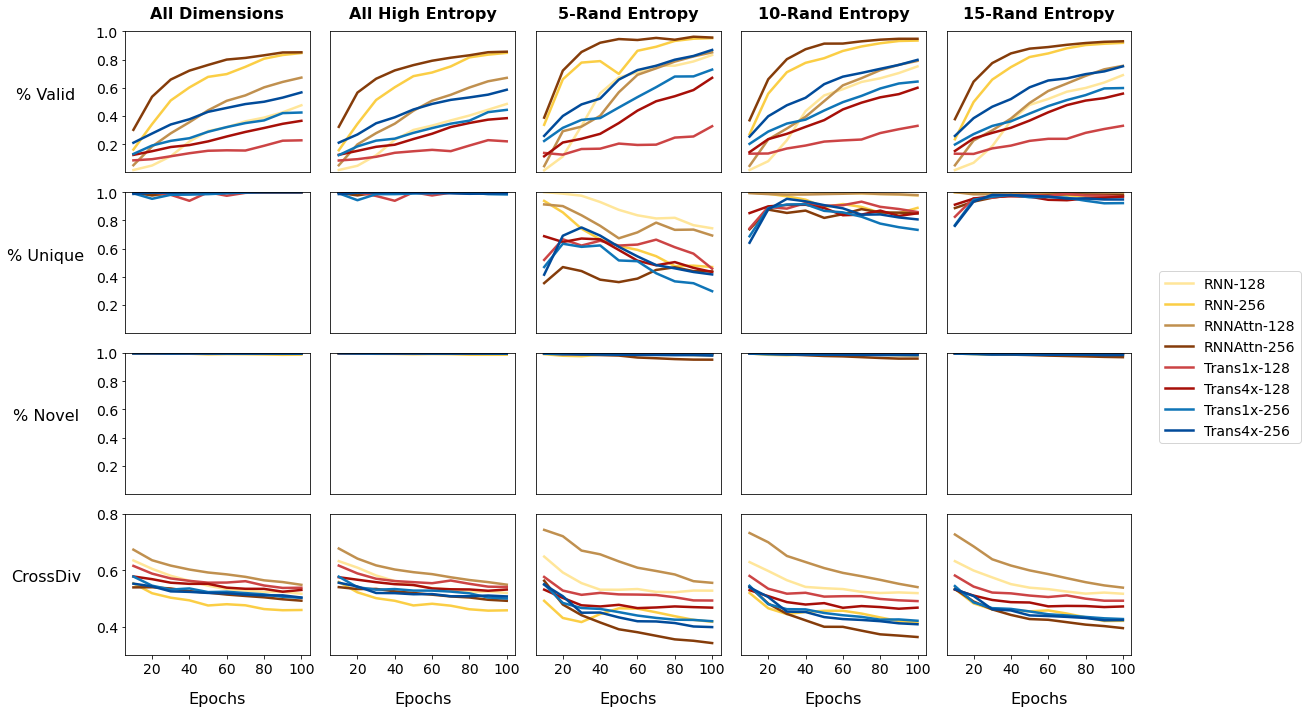

In [107]:
with open('../eval/all_model_metrics_moses.json', 'r') as f:
    data_dict = json.load(f)

sampling_modes = ['_rand', '_high_entropy', '_krand_high_entropy_5', '_krand_high_entropy_10',
                  '_krand_high_entropy_15']
titles = ['All Dimensions', 'All High Entropy', '5-Rand Entropy', '10-Rand Entropy', '15-Rand Entropy']
data_types = ['valid_filter', 'unique_filter', 'novel_filter', 'crossdiv_train']
ylabels = ['% Valid', '% Unique', '% Novel', 'CrossDiv']
model_fns = ['128_latent128_2milmoses_gruvae_v0.3',
               '256_latent128_2milmoses_gruvae_v0.3',
               '128_latent128_2milmoses_gruavae_v0.3',
               '256_latent128_2milmoses_gruavae_v0.3',
               '128_1x_latent128_2milmoses_tvae_v0.4',
               '128_4x_latent128_2milmoses_tvae_v0.4',
               '256_1x_latent128_2milmoses_tvae_v0.4',
               '256_4x_latent128_2milmoses_tvae_v0.4']
model_names = ['RNN-128', 'RNN-256', 'RNNAttn-128', 'RNNAttn-256',
               'Trans1x-128', 'Trans4x-128', 'Trans1x-256', 'Trans4x-256']
xlabels = ['20', '40', '60', '80', '100']

colors = ['#FFE69A', '#FBCE45','#C0904F', '#853C0A',
          '#CC4445', '#A70F08', '#0F75B7', '#014B9A']

fig, axs = plt.subplots(4, 5, figsize=(16,10))
for i, data_type in enumerate(data_types):
    for j, sampling_mode in enumerate(sampling_modes):
        for k, model_fn in enumerate(model_fns):
            data = data_dict['{}{}'.format(model_fn, sampling_mode)][data_type]
            if sampling_mode == '_rand' and data_type == 'valid_filter':
                print(model_fn, data[-1])
            if sampling_mode == '_rand' and data_type == 'crossdiv_train':
                print(model_fn, data[-1])
            if sampling_mode == '_krand_high_entropy_15' and data_type == 'valid_filter':
                print(model_fn, data[-1])
            if sampling_mode == '_krand_high_entropy_15' and data_type == 'crossdiv_train':
                print(model_fn, data[-1])
            axs[i,j].plot(data, label=model_names[k], color=colors[k], lw=2.5)
        if i == 0:
            axs[i,j].set_title('{}'.format(titles[j]), fontsize=16, fontweight='bold', y=1.05)
        if i == 3:
            axs[i,j].set_xticks([1,3,5,7,9])
            axs[i,j].set_xticklabels(labels=xlabels)
            axs[i,j].set_ylim([0.3,0.8])
            axs[i,j].set_yticks([0.4, 0.6, 0.8])
            axs[i,j].set_yticklabels(labels=[0.4, 0.6, 0.8], size=14)
            axs[i,j].set_xlabel('Epochs', fontsize=16, labelpad=15)
        else:
            axs[i,j].set_ylim([0,1])
            axs[i,j].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
            axs[i,j].set_yticklabels(labels=[0.2, 0.4, 0.6, 0.8, 1.0], size=14)
        if j == 0:
            axs[i,j].set_ylabel(ylabels[i], rotation=0, fontsize=16, labelpad=50)

for i, ax in enumerate(fig.axes):
    if i < 15:
        ax.set_xticks([])
    else:
        ax.set_xticks([1,3,5,7,9])
        ax.set_xticklabels(labels=xlabels, size=14)
    if i % 5 == 0:
        pass
    else:
        ax.set_yticks([])
fig.tight_layout()
plt.legend(loc=(1.15, 1.5), fontsize=14)
plt.show()

# Model Size and Efficiency

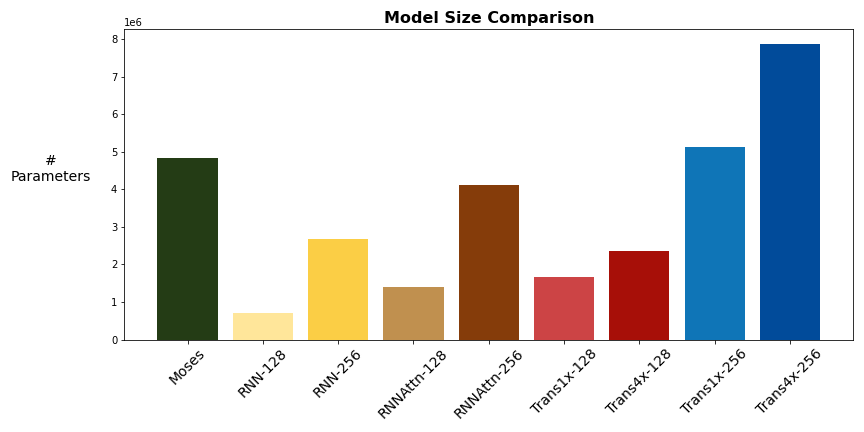

In [18]:
Image(filename='../../../publications/transvae/figs/si_fig1.png')

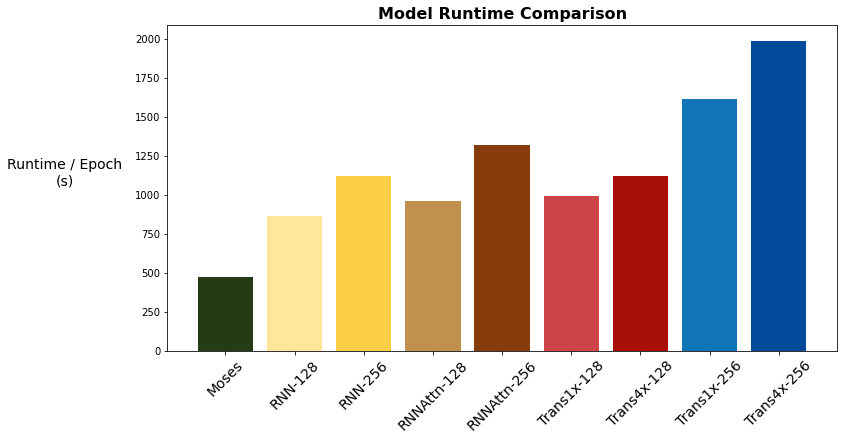

In [17]:
logs = ['../trials/log_128_latent128_2milmoses_gruvae_v0.3.txt',
        '../trials/log_256_latent128_2milmoses_gruvae_v0.3.txt',
        '../trials/log_128_latent128_2milmoses_gruavae_v0.3.txt',
        '../trials/log_256_latent128_2milmoses_gruavae_v0.3.txt',
        '../trials/log_128_1x_latent128_2milmoses_tvae_v0.4.txt',
        '../trials/log_128_4x_latent128_2milmoses_tvae_v0.4.txt',
        '../trials/log_256_1x_latent128_2milmoses_tvae_v0.4.txt',
        '../trials/log_256_4x_latent128_2milmoses_tvae_v0.4.txt']

run_times = []
df = pd.read_csv('../trials/run_log_moses.txt')
run_times.append(df[df['mode'] == 'Train']['run_time'].mean())

for fn in logs:
    df = pd.read_csv(fn)
    avg_runtime = df[df.data_type == 'train'].groupby('epoch').sum()['run_time'].mean()
    run_times.append(avg_runtime)

labels = ['Moses', 'RNN-128', 'RNN-256', 'RNNAttn-128', 'RNNAttn-256', 'Trans1x-128', 'Trans4x-128',
          'Trans1x-256', 'Trans4x-256']
barwidth = 0.25

colors = ['#243C15', '#FFE69A', '#FBCE45','#C0904F', '#853C0A',
          '#CC4445', '#A70F08', '#0F75B7', '#014B9A']

fit = plt.figure(figsize=(12,6))
plt.bar(range(len(run_times)), run_times, color=colors[:len(run_times)])
plt.xticks(range(len(run_times)), labels, rotation=45, fontsize=14)
plt.ylabel('Runtime / Epoch\n(s)', rotation=0, fontsize=14, labelpad=70)
plt.title('Model Runtime Comparison', fontsize=16, fontweight='bold')
plt.show()